# Fraud Detection Assignment

## Motivation

### It is important that financial companies are able to recognize fraudulent transactions so that customers are not charged for items that they did not purchase. In this assignment we will be implementing anamoly detection to detect whether there is any fraudulent transaction. 

## Outlier Detection

### Outlier Detection aka Anomaly Detection is a step in data mining that identifies data points, events and/or observations that deviate from a dataset's normal behaviour.

## Importing libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import scipy 
from sklearn.metrics import classification_report, accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


## Importing Libraries for Outlier Detection

In [2]:
from sklearn.ensemble import IsolationForest

## Reading our Dataset

In [3]:
df = pd.read_csv('../input/paysim1/PS_20174392719_1491204439457_log.csv')

In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Correcting the spelling of original column headers for consistency

In [5]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [6]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest           object
oldBalanceDest    float64
newBalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
df.shape

(6362620, 11)

## Checking Null Values

In [8]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
df.isnull().values.any()

False

## Exploratory Data Analysis

### Which types of transactions are fraudulent?


We find that out of the five types of transactions, fraud occurs only in two of them : 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs.fraud is committed by first transferring out funds to another account which subsequently cashes it out. 

In [10]:
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
                                                             # & 'TRANSFER'

dft = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfc = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dft))) # 4097

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfc))) # 4116


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


### What determines whether the feature isFlaggedFraud gets set or not?


It turns out that the origin of isFlaggedFraud is unclear, contrasting with the description provided. The 16 entries (out of 6 million) where the isFlaggedFraud feature is set do not seem to correlate with any explanatory variable. The data is described as isFlaggedFraud being set when an attempt is made to 'TRANSFER' an 'amount' greater than 200,000. In fact, as shown below, isFlaggedFraud can remain not set despite this condition being met.

In [11]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            # only 'TRANSFER'

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min())) # 353874.22

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) # 92445516.64


The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


Although isFraud is always set when isFlaggedFraud is set, since isFlaggedFraud is set just 16 times in a seemingly meaningless way, we can treat this feature as insignificant and discard it in the dataset without loosing information.

### Are expected merchant accounts accordingly labelled?
It was stated that CASH_IN involves being paid by a merchant (whose name is prefixed by 'M'). However, as shown below, the present data does not have merchants making CASH_IN transactions to customers.

In [12]:
print('\nAre there any merchants among originator accounts for CASH_IN \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) # False


Are there any merchants among originator accounts for CASH_IN transactions? False


Similarly, it was stated that CASH_OUT involves paying a merchant. However, for CASH_OUT transactions there are no merchants among the destination accounts.

In [13]:
print('\nAre there any merchants among destination accounts for CASH_OUT \
transactions? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) # False


Are there any merchants among destination accounts for CASH_OUT transactions? False


In fact, there are no merchants among any originator accounts. Merchants are only present in destination accounts for all PAYMENTS

In [14]:
print('\nAre there merchants among any originator accounts? {}'.format(\
      df.nameOrig.str.contains('M').any())) # False

print('\nAre there any transactions having merchants among destination accounts\
 other than the PAYMENT type? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) # False


Are there merchants among any originator accounts? False

Are there any transactions having merchants among destination accounts other than the PAYMENT type? False


Conclusion: Among the account labels nameOrig and nameDest, for all transactions, the merchant prefix of 'M' occurs in an unexpected way.

### Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?
From the data description, the modus operandi for committing fraud involves first making a TRANSFER to a (fraudulent) account which in turn conducts a CASH_OUT. CASH_OUT involves transacting with a merchant who pays out cash. Thus, within this two-step process, the fraudulent account would be both, the destination in a TRANSFER and the originator in a CASH_OUT. However, the data shows below that there are no such common accounts among fraudulent transactions. Thus, the data is not imprinted with the expected modus-operandi.

In [15]:
print('\nWithin fraudulent transactions, are there destinations for TRANSFERS \
that are also originators for CASH_OUTs? {}'.format(\
(dft.nameDest.isin(dfc.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Within fraudulent transactions, are there destinations for TRANSFERS that are also originators for CASH_OUTs? False


Could destination accounts for fraudulent TRANSFERs originate CASHOUTs that are not detected and are labeled as genuine? It turns out there are 3 such accounts.

In [16]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dft.loc[dft.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


However, 2 out of 3 of these accounts first make a genuine CASH_OUT and only later (as evidenced by the time step) receive a fraudulent TRANSFER. Thus, fraudulent transactions are not indicated by the nameOrig and nameDest features.

In [17]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) # 185


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


Conclusion: Noting from above suggests that the nameOrig and nameDest features neither encode merchant accounts in the expected way, below, we drop these features from the data since they are meaningless.

## Nomral and Fraud Distribution

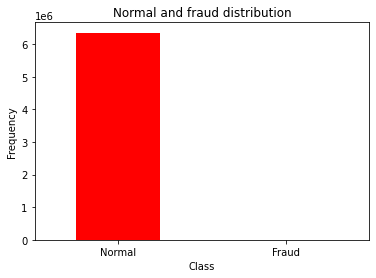

In [18]:
fraud_check = pd.value_counts(df['isFraud'], sort =True)
fraud_check.plot(kind = 'bar', rot=0, color='r')
plt.title("Normal and fraud distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
Labels = ['Normal','Fraud']
plt.xticks(range(2), Labels)
plt.show()

### Lets us see what is the shape of normal and fraud data set

In [19]:
fraud_people = df[df['isFraud']==1]
normal_people = df[df['isFraud']==0]

In [20]:
fraud_people.shape

(8213, 11)

In [21]:
normal_people.shape

(6354407, 11)

### Finding out the avg amount in our both data sets

In [22]:
fraud_people['amount'].describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [23]:
normal_people['amount'].describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

### Let us analyse it visually

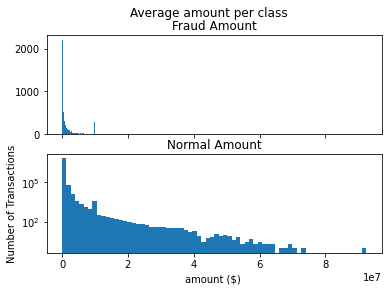

In [24]:
graph, (plot1, plot2) = plt.subplots(2,1,sharex = True) #sharex used to avoid overlapping of titles
graph.suptitle("Average amount per class")
bins = 70

plot1.hist(fraud_people['amount'], bins = bins)
plot1.set_title('Fraud Amount')

plot2.hist(normal_people['amount'], bins = bins)
plot2.set_title('Normal Amount')

plt.xlabel('amount ($) ')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

## Correlation Heatmap

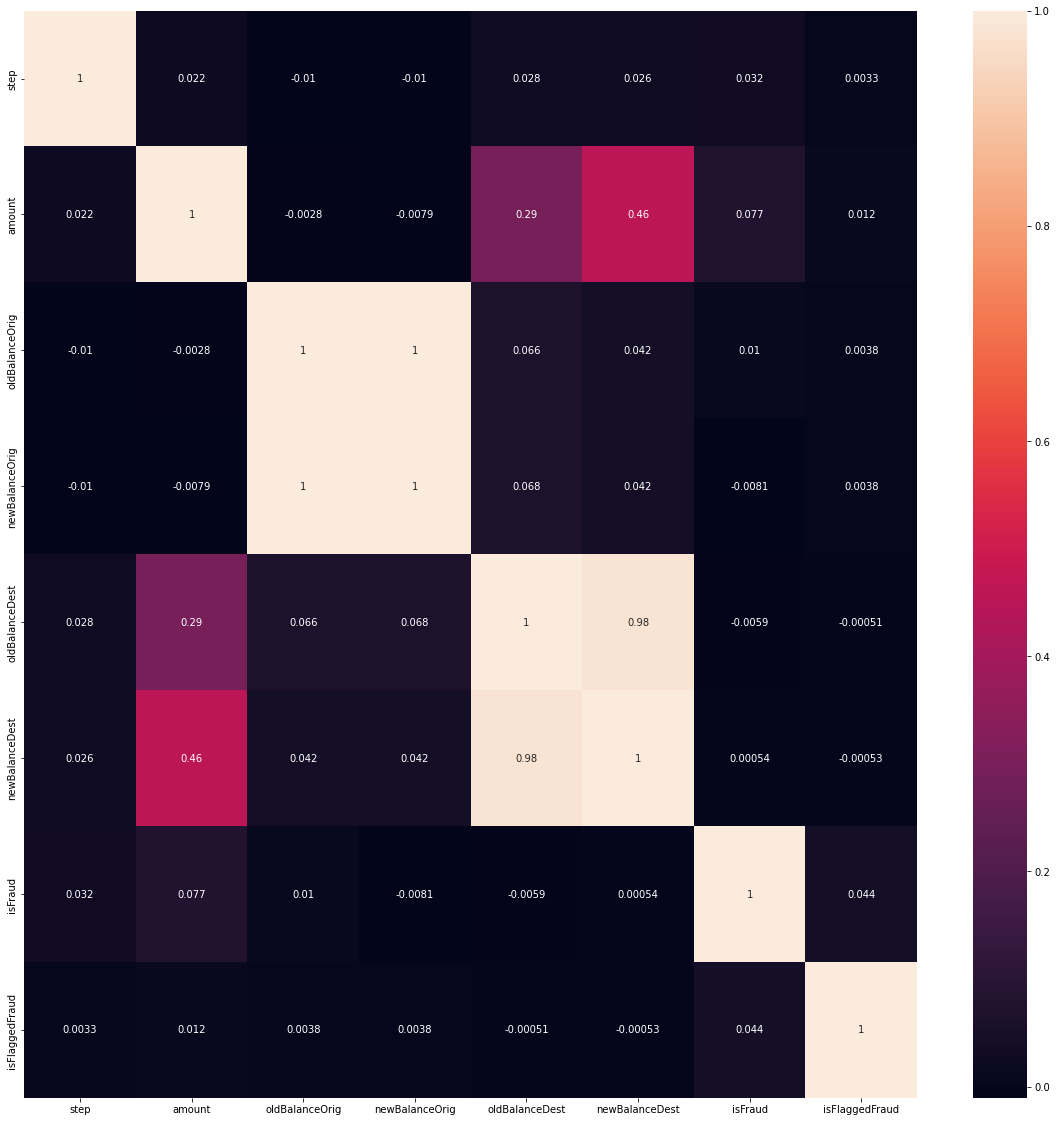

In [25]:
df.corr
plt.figure(figsize =(20,20))
g=sns.heatmap(df.corr(),annot=True) #annet used to add text

## Creating our Dependent and Independent Features

In [26]:
columns = df.columns.tolist()
# Making our independent Features
columns = [var for var in columns if var not in ["isFraud"]]
# Making our Dependent Variable
target = "isFraud"
x = df[columns]
y = df[target]

### Label Encoding

In [27]:
x['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1','2','3','4','5',], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [28]:
x.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1, inplace=True)
x.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
0,1,4,9839.64,170136.0,160296.36,0.0,0.0
1,1,4,1864.28,21249.0,19384.72,0.0,0.0
2,1,5,181.00,181.0,0.00,0.0,0.0
3,1,2,181.00,181.0,0.00,21182.0,0.0
4,1,4,11668.14,41554.0,29885.86,0.0,0.0


In [29]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

## Model Building

### Splitting the data

In [30]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.30, random_state = 42)

### We will be using the Isolation Forest for our Anamoly Detection

## Isolation Forest

### One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

### This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Morever, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a dataset.

### Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviours are present in the dataset.

### How Isolation Forests Work - the Isolation Forest algorithm observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes isolating anomaly observations is easier because only a few conditons are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

### The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then the score is calculated as the path length to isolate the observation.

In [31]:
iso_forest = IsolationForest(n_estimators =100, max_samples = len(x_train), random_state=0, verbose=0)

In [32]:
iso_forest.fit(x_train,y_train)

IsolationForest(max_samples=4453834, random_state=0)

In [33]:
ypred = iso_forest.predict(x_test)

### Mapping the values as we want to have an output in 0 and 1

In [34]:
ypred[ypred == 1] = 0
ypred[ypred == -1] = 1

## Accuracy score and Matrix

In [35]:
print(accuracy_score(y_test,ypred))

0.9931794344677717


In [36]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906351
           1       0.05      0.22      0.08      2435

    accuracy                           0.99   1908786
   macro avg       0.52      0.61      0.54   1908786
weighted avg       1.00      0.99      1.00   1908786



In [37]:
from sklearn.metrics import confusion_matrix

In [38]:
confusion_matrix(y_test, ypred)

array([[1895225,   11126],
       [   1893,     542]])

### We can also print how many error our model have

In [39]:
n_erorrs = (ypred != y_test).sum()
print("Isolation Forest have {} erorrs.".format(n_erorrs))

Isolation Forest have 13019 erorrs.
